In [ ]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from analysis import collection, analysis, emg
from analysis import plot as analysis_plot
import scipy as sp
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture
from sklearn.base import clone
import seaborn as sns
import pickle
from scipy.stats import multivariate_normal

%matplotlib inline

## look at GMM covariance task/null space projections

In [ ]:
# test subspace projection
task, null = analysis.compute_subspaces(decoder)
print(task.shape, null.shape)

(2, 64) (62, 64)


In [ ]:
def stacked_subspace_projection(C,d):
    t, n = analysis.compute_subspaces(d)
    s = np.row_stack([t,n])
    return analysis.subspace_projection(C, s)

In [ ]:
# project each component of each model
# model, component, projection vec
projections = np.zeros(shape=(5,4,64))
markers = [".","*","o","v","s"]
for i, model in enumerate(models):
    for k, cov in enumerate(model.covariances_):
        projections[i,k,:] = stacked_subspace_projection(cov,decoder)

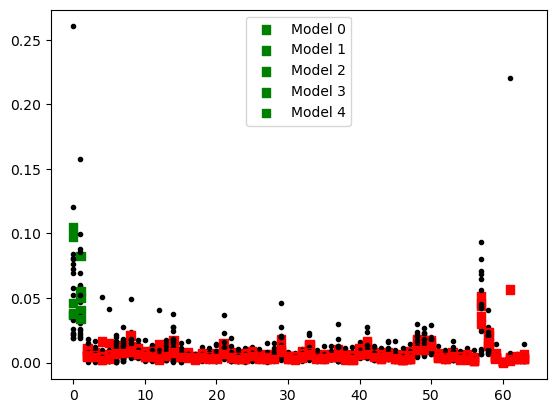

In [ ]:
# plot the projections and color the mean for each model
for model_idx in range(5):
    for cpt_idx in range(4):
        p = projections[model_idx, cpt_idx]
        plt.scatter(np.arange(p.shape[0]), p, color="k", marker=".")
    plt.scatter(np.arange(p.shape[0]), np.mean(projections, axis=1)[model_idx], marker=markers[i], c=["g","g"] + ["r" for _ in range(62)], label=f"Model {model_idx}")
plt.legend()

In [ ]:
task, null = analysis.compute_subspaces(decoder)
mean_projections = np.zeros(shape=(5,4,3))
markers = [".","*","o","v","s"]
print(task.shape, null.shape)
for i, model in enumerate(models):
    for k, cov in enumerate(model.covariances_):
        mean_projections[i,k,0] = analysis.mean_quadratic_form(cov,task)[0] # *models[i].weights_[k]
        mean_projections[i,k,1] = analysis.mean_quadratic_form(cov,null)[0] # *models[i].weights_[k]
        mean_projections[i,k,2] = mean_projections[i,k,0] / mean_projections[i,k,1]

(2, 64) (62, 64)


Text(0, 0.5, 'Task/Null Ratio')

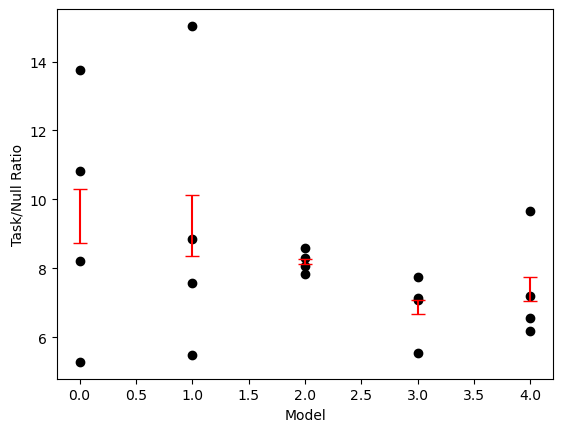

In [ ]:
for i in range(5):
    for k in range(4):
        plt.plot(i, mean_projections[i,k,2],'ko')
plt.errorbar(x=list(range(5)),y=np.mean(mean_projections[:,:,2],axis=1),yerr=np.std(mean_projections[:,:,2],axis=1)/4,color='r',capsize=5,linestyle="none")
plt.xlabel("Model")
plt.ylabel("Task/Null Ratio")

#### To look at task/null variance, we need to focus on the ERROR signal-- this is the NOISE apart from doing the task itself. 

#### BUT we can't do this! Because we don't have a trajectory --> EMG model... we can:
- try to interpret this in light of the task data
- fit a model from trajectory to EMG, then subtract that off from the EMG? E.g. A*t = e', err = |e - e'|**2 ?

If we take the HIT emg ends, stack those, then fit a model from that point to that EMG activity, then we could subtract that EMG activity off of the other EMG.

Now we have error_emg for every trial. Then we can try to project.

What we have now is still interesting, it's looking at on-manifold activity vs. off. But this is kind of "manifold activity" (are we moving on or off manifold), less specific than "manifold error" (are we making mistakes / irrelevant activity on or off manifold).